Prototyping of the case of perspective warping of an image based on a sheet of A4 paper.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
import os
import sys
from matplotlib import pyplot as plt

In [3]:
CODE_DIR = os.environ['CODEROOT']
for lib_name in ('visionfuncs', ):
    lib_path = os.path.join(CODE_DIR, lib_name)
    if lib_path not in sys.path:
        sys.path.append(lib_path)

In [4]:
from visionfuncs import io
from visionfuncs import improc
from visionfuncs import corners
from visionfuncs import regions
from visionfuncs import lines
from visionfuncs import geometry
from visionfuncs import viz

In [5]:
from helpers import imshow, show_channels

In [6]:
im = io.open_image('books_a4.jpg', cv2.IMREAD_COLOR, cv2.COLOR_BGR2RGB)

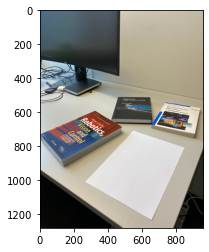

In [7]:
plt.imshow(im)
plt.show()

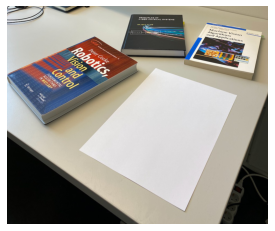

In [8]:
im_cropped = im[480:, :]

imshow(im_cropped)

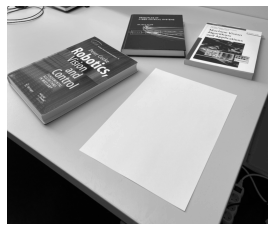

In [9]:
im_gray = cv2.cvtColor(im_cropped, cv2.COLOR_RGB2GRAY)

imshow(im_gray, cmap='gray')

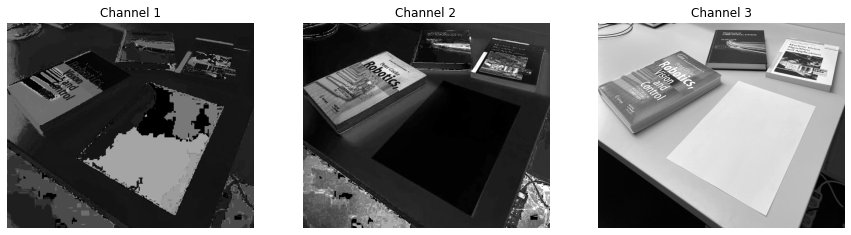

In [10]:
im_hsv = cv2.cvtColor(im_cropped, cv2.COLOR_RGB2HSV)

show_channels(im_hsv)

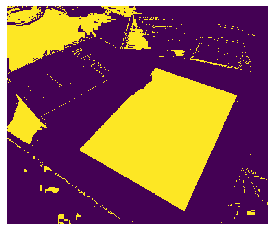

In [11]:
im_sat_thresh = regions.threshold_binary_inv(im_hsv[:, :, 1], 15)

imshow(im_sat_thresh, interpolation='none')

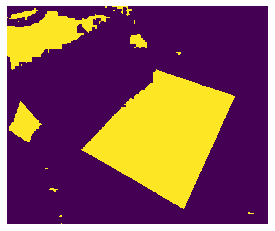

In [12]:
im_eroded = improc.erode(im_sat_thresh, kernel_size=9, n_iter=1)

imshow(im_eroded, interpolation='none')

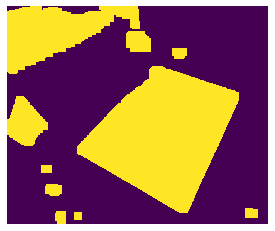

In [13]:
im_dilated = improc.dilate(im_eroded, kernel_size=15, n_iter=2)

imshow(im_dilated, interpolation='none')

In [14]:
ccomp_labels, ccomp_stats = regions.find_ccomp(im_eroded)

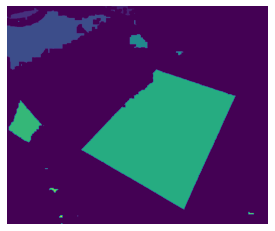

In [15]:
imshow(ccomp_labels)

In [16]:
largest_component = ccomp_stats.iloc[
    ccomp_stats.iloc[1:]['area'].argmax() + 1
]

largest_component

left         273.000000
top          233.000000
width        567.000000
height       514.000000
area      152609.000000
x            576.379604
y            474.517073
Name: 13, dtype: float64

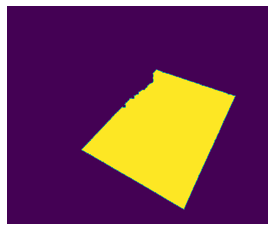

In [17]:
largest_component_mask = np.array(ccomp_labels == largest_component.name, dtype=np.uint8)

imshow(largest_component_mask)

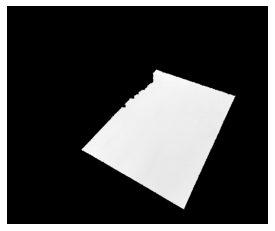

In [18]:
im_masked = regions.apply_mask(im_gray, largest_component_mask)

imshow(im_masked, cmap='gray')

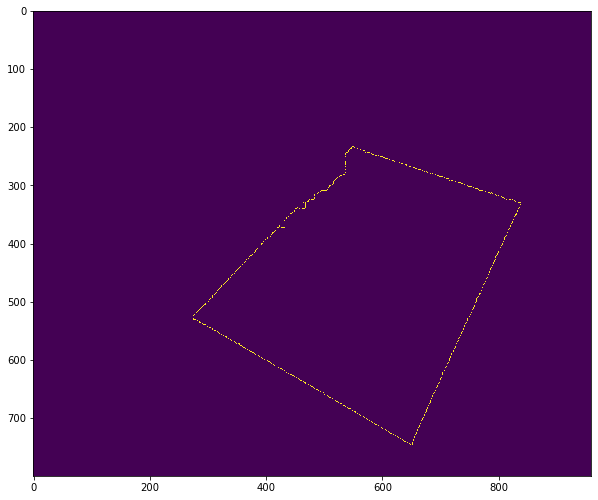

In [19]:
im_edges = cv2.Canny(im_masked, 150, 200)

plt.figure(figsize=(10, 15))
plt.imshow(im_edges, interpolation='none')

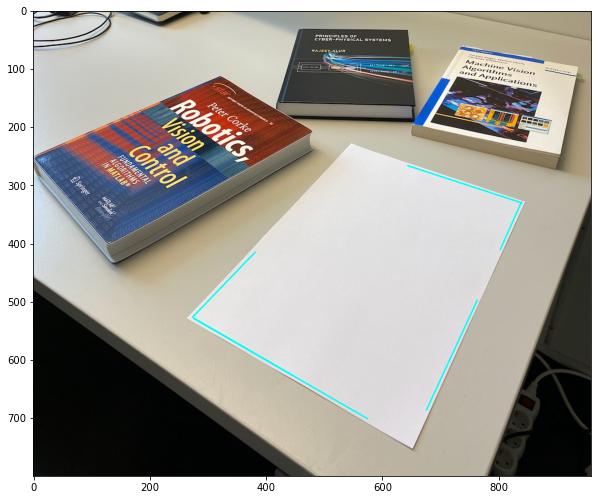

In [20]:
paper_lines = lines.hough_lines(im_edges, 2, np.pi/180, 150, 50, 10)

plt.figure(figsize=(10, 15))
_ = plt.imshow(im_cropped)

for line in paper_lines:
    viz.plot_line(line, color='cyan')

In [21]:
paper_lines

array([[276, 529, 446, 627],
       [275, 528, 574, 701],
       [676, 686, 763, 498],
       [274, 526, 381, 415],
       [644, 266, 840, 330],
       [803, 410, 839, 329]], dtype=int32)

In [22]:
line_vecs = lines.opencv_points_to_line_vectors(paper_lines)

line_vecs

array([[ 1.55847460e-03, -2.70347635e-03,  1.00000000e+00],
       [ 1.56849234e-03, -2.71086249e-03,  1.00000000e+00],
       [-1.00658564e-03, -4.65813567e-04,  1.00000000e+00],
       [-1.28033589e-03, -1.23419766e-03,  1.00000000e+00],
       [ 5.86080586e-03, -1.79487179e-02,  1.00000000e+00],
       [-1.01499944e-03, -4.51110860e-04,  1.00000000e+00]])

In [23]:
def corners_from_lines(opencv_lines, im_shape):
    
    n_rows, n_cols = im_shape[:2]
    
    def point_is_ok(p):
        
        if p[0] < 0:
            return False
        
        if p[1] < 0:
            return False
        
        if p[0] >= n_cols:
            return False
        
        if p[1] >= n_rows:
            return False
        
        return True
    
    n_lines = len(opencv_lines)
    
    line_vecs = lines.opencv_points_to_line_vectors(opencv_lines)
    
    res = []
    
    for i in range(n_lines):
        for j in range(i + 1, n_lines):
            
            line_i = line_vecs[i]
            line_j = line_vecs[j]
            
            p_homog = np.cross(line_i, line_j)
            p = geometry.h2e(p_homog)
            
            if point_is_ok(p):
                res.append(p)
                
    return np.array(res)

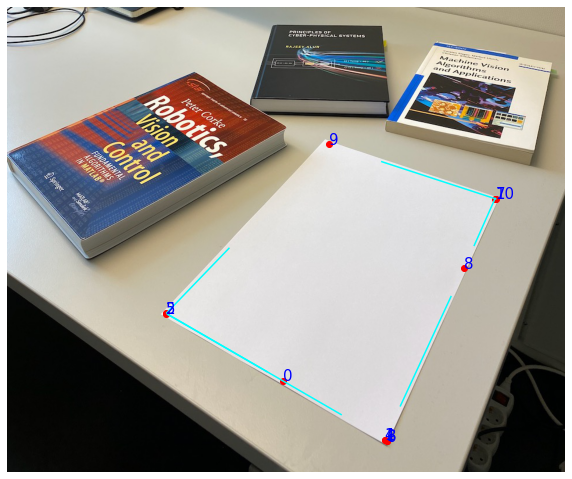

In [24]:
cfl = corners_from_lines(paper_lines, im_cropped.shape)

plt.figure(figsize=(10, 15))
plt.imshow(im_cropped)
plt.axis('off')

for line in paper_lines:
    viz.plot_line(line, color='cyan')
    
plt.scatter(cfl[:, 0], cfl[:, 1], color='red')

ax = plt.gca()

for i, coord in enumerate(cfl):
    ax.annotate(i, coord, color='blue', size=15)

plt.show()

Dimension of an A4 paper: 210 x 297 mm

In [25]:
def create_rectangle_points(origin, width, height):
    
    x, y = origin
    
    points = np.array(
        [
            [x, y],
            [x+width, y],
            [x+width, y+height],
            [x, y+height],
        ], 
        dtype=np.float32
    )

    return points

In [26]:
dst_points = create_rectangle_points(origin=(10, 300), width=210, height=297)

dst_points

array([[ 10., 300.],
       [220., 300.],
       [220., 597.],
       [ 10., 597.]], dtype=float32)

In [27]:
src_points = np.array(
    [
        cfl[0],
        cfl[2],
        cfl[3],
        cfl[1]
    ],
    dtype=np.float32
)

In [28]:
M = cv2.getPerspectiveTransform(src_points, dst_points)

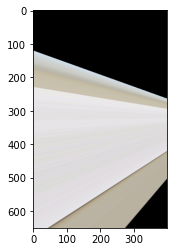

In [29]:
im_warped = cv2.warpPerspective(im_cropped, M, (400, 650), flags=cv2.INTER_LINEAR)

#plt.figure(figsize=(10, 10))
plt.imshow(im_warped)
plt.show()